# Basic Introduction to Pairs Trading on Quantopian

The following presentation is heavily adapted from Delaney Granizo-Mackenzie's "Researching a Pairs Trading Strategy" presentation (https://notebooks-prod.herokuapp.com/previews?key=5346083a839ff34e1400010a%2Ffabe9a1d-6c50-4dbd-a636-4218b57c206f%2Fpreview.html&vf=true). 

We have simplified it for the sake of our Senior Seminar presentation, but we *fully credit* all code and work to Delaney. This is simply meant to demonstrate Pairs Trading on the most basic level so the class may understand how it works before we dive into the mathematical components.


---



In [3]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

## Explaining the Concept: Generating Two Fake Securities
Let us create two dummy stocks, X and Y. We first model X's daily returns by drawing from a normal distribution and sum/shift them so that the prices are in a reasonable range.

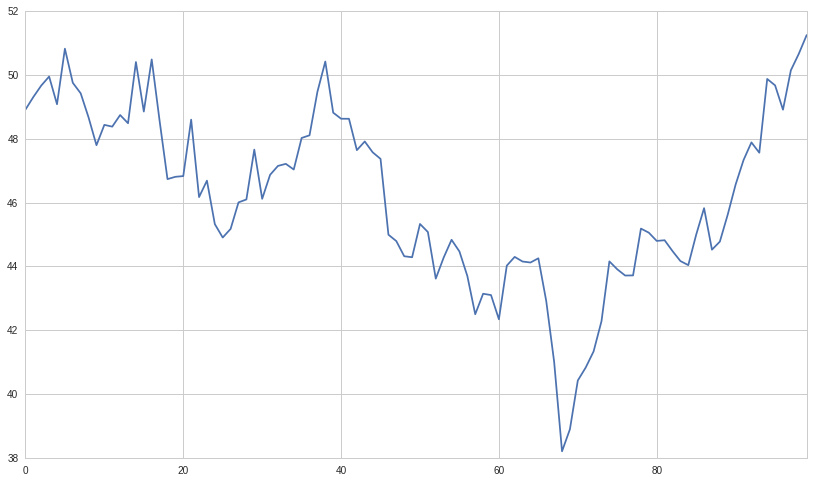

In [19]:
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot()

We then generate Y by shifting X up and adding some random noise, drawing random samples from a normal distribution. 

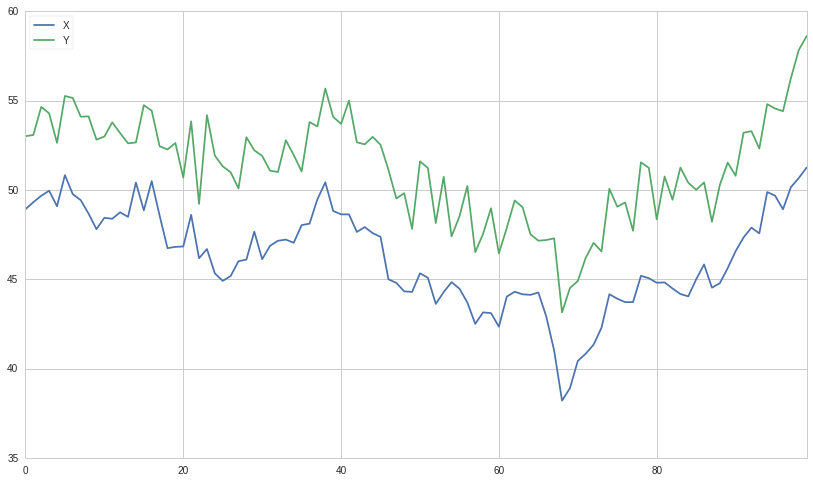

In [20]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot()

##Using X and Y to Demonstrate Cointegration

X and Y, in this case, is an example of a cointegrated series. The "spread" (difference in prices) between the two timeseries will vary around a mean, and the expected value of the spread over time must converge to the mean in order for pairs trading to work. ("Cointegration tells you whether the distance between them remains the same over time.")

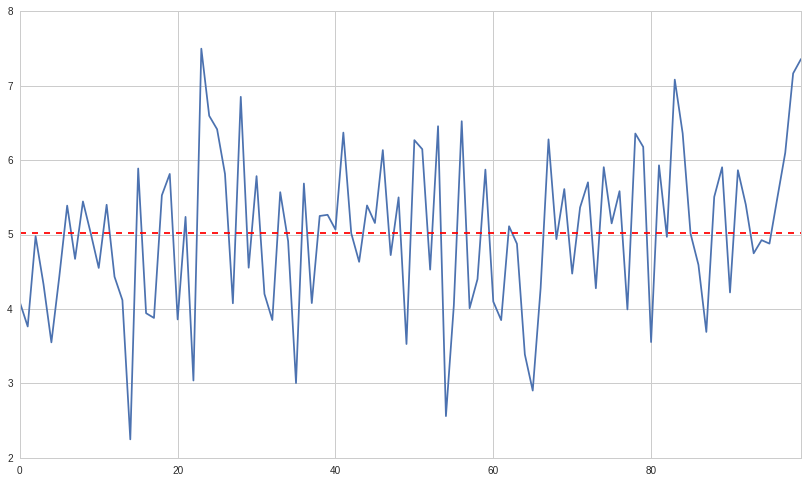

In [21]:
(Y-X).plot() # Plot the spread
plt.axhline((Y-X).mean(), color='red', linestyle='--') # Add the mean

##Testing for Cointegration

To test for cointegration, we compute the p-value. If it's very low, then co-integration exists! This is a simplification of how we can test for cointegration as Python has a built in "coint" function that uses the unit-root test on residuals to test for cointegrated relationship

In [23]:
# compute the p-value of the cointegration test
# will inform us as to whether the spread btwn the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)
print pvalue

1.04381026894e-12


## Hedged Positions & Applications to Pairs Trading
In pairs trading, we maintain a "hedged position" to protect ourselves from market volatility, meaning we are immune to extreme market events such as a recession. In this case, we "long" one stock and "short" the other. When X and Y are far apart, then we short Y and long X. When they're close together, we do the opposite.

## Moving onto real stocks
We now test for cointegration between actual stocks by performing a statistical test on stocks we think are co-integrated.

This method written by Delaney looks at a list of stocks and tests for cointegration between all of them.

In [7]:
def find_cointegrated_pairs(securities_panel):
    n = len(securities_panel.minor_axis)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities_panel.keys
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = securities_panel.minor_xs(securities_panel.minor_axis[i])
            S2 = securities_panel.minor_xs(securities_panel.minor_axis[j])
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((securities_panel.minor_axis[i], securities_panel.minor_axis[j]))
    return score_matrix, pvalue_matrix, pairs

## Looking for Cointegrated Pairs of Tech Stocks
Let's take a look at a bunch of different stocks in the tech industry and see if any of them are cointegrated, specifically looking at the daily closing price of the stock from 2017 to 2018.

In [8]:
symbol_list = ['TTWO', 'ATVI', 'EA', 'NVDA', 'FB', 'TWTR']
securities_panel = get_pricing(symbol_list, fields=['price']
                               , start_date='2017-01-01', end_date='2018-01-01')
securities_panel.minor_axis = map(lambda x: x.symbol, securities_panel.minor_axis)

In [9]:
securities_panel.loc['price'].head(5)

,TTWO,ATVI,EA,NVDA,FB,TWTR
2017-01-03 00:00:00+00:00,49.22,36.407,79.16,101.604,116.850,16.430
2017-01-04 00:00:00+00:00,50.14,37.133,80.63,103.995,118.691,16.860
2017-01-05 00:00:00+00:00,49.36,37.709,78.95,101.345,120.670,17.100
2017-01-06 00:00:00+00:00,49.95,37.659,79.01,102.730,123.430,17.175
2017-01-09 00:00:00+00:00,50.46,37.471,78.64,106.874,124.920,17.510


Now we'll run our method on the list and see if any pairs are cointegrated.

[(u'TTWO', u'FB')]


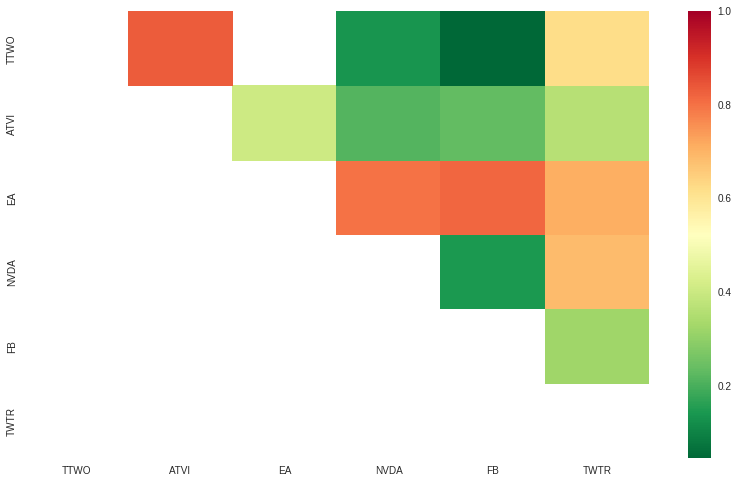

In [10]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
# (Just showing a '1' for everything in lower diagonal)

scores, pvalues, pairs = find_cointegrated_pairs(securities_panel)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.95)
                )
print pairs

Looks like 'TTWO' and 'FB' are cointegrated. Just to double check....

In [11]:
S1 = securities_panel.loc['price']['TTWO']
S2 = securities_panel.loc['price']['FB']

In [12]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.046022074339030508

Now let's visualize the spread of the two stocks.

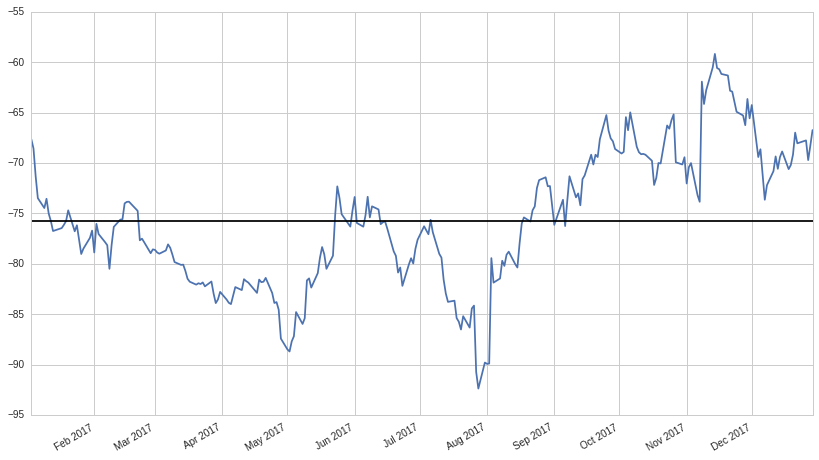

In [13]:
diff_series = S1 - S2
diff_series.plot()
plt.axhline(diff_series.mean(), color='black')

So what do we do about the spread? If we normalize our signal, treating it as a z-score, we can associate probabilities to the signals we see. A z-score of 1 means that ~84% of spread values will be smaller.

In [14]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

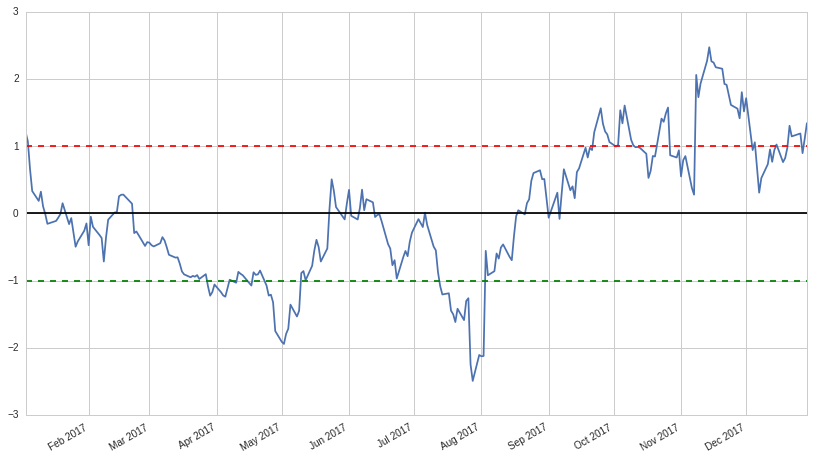

In [15]:
zscore(diff_series).plot()
plt.axhline(zscore(diff_series).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')


### Simple Strategy: 
* When the z-score is above 1.0, we buy 1 share of S2 and short 1 share of S1
* When the z-score is below -1.0, we buy 1 share of S1 and short 1 share of S2
* We exit our positions when the z-score approaches 0
* Spread is defined as S1-S2, hence our positions. Sell the one whose price goes up and buy the one whose price goes down.

### Testing this: 
* https://www.quantopian.com/algorithms/5dca10fbd9af2e151761e3e4

### Some Comments:
This is the most basic way to conduct pairs trading. On a more high level, one may consider using more sophisticated statistics such as:
* Augmented-Dickey Fuller test (will be discussed later) 
* Hurst exponent
* Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process (will be discussed later)
* Kalman filters